In [1]:
import os
import random
from datasets import load_dataset, Dataset
from tqdm import tqdm
import polars as pl
from concurrent.futures import ProcessPoolExecutor
import spacy
import numpy as np
from functools import partial
import re
from PIL import Image
import torch
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import diffusers
from diffusers.image_processor import VaeImageProcessor
from diffusers import AutoencoderKL, DDPMScheduler

pl.Config.set_fmt_str_lengths(200)

/home/enric/projects/tiny_diffusion/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


polars.config.Config

In [2]:
PATH = '/mnt/sd1tb/tinydiffusion/dataset_v0/'

In [3]:
def show_image(df, idx=None):
    if idx is None:
        idx = random.randint(0, len(df))
    row = df[idx]
    path = row['path'][0]
    prompt = row['caption'][0]
    img = Image.open(path)
    h, w = row['height'][0], row['width'][0]
    print(h, w)
    print(prompt)
    plt.figure(figsize=(8, 10))
    plt.imshow(img)
    # plt.title(prompt, {'fontsize': 14})
    plt.axis('off')

In [4]:
df_consolidated = pl.read_parquet(
    PATH + 'dataset_gold.parquet'
)

In [5]:
df_consolidated.head(3)

id,caption,url,key,status,error_message,width,height,original_width,original_height,exif,sha256,path
str,str,str,str,str,str,i32,i32,i32,i32,str,str,str
"""940948014624""","""Happy smiling Boy Playing Outdoor with Parents In Summer Sunny Day""","""https://thumb9.shutterstock.com/image-photo/stock-photo-happy-smiling-boy-playing-outdoor-with-parents-in-summer-sunny-day-450w-31714474.jpg""","""000000006""","""success""",null,301,470,301,470,"""{}""","""0ec8f315dc39b96a8177d11e7d0dead9c8ba59f0aef31d7eaa033a800b5d3267""","""/mnt/sd1tb/tinydiffusion/dataset_v0/imgs/00000/000000006.jpg"""
"""140086000679""","""Two Piggy Banks With Money Saving Coupons And Deals photo""","""https://us.123rf.com/450wm/karenkh/karenkh1201/karenkh120100021/12001156-two-piggy-banks-with-money-saving-coupons-and-deals.jpg""","""000000008""","""success""",null,450,300,450,300,"""{}""","""9f91d56bcf11c70c56913a454ffe059d72c4ac0b26df503209d338b6555f4cd3""","""/mnt/sd1tb/tinydiffusion/dataset_v0/imgs/00000/000000008.jpg"""
"""186279001985""","""Background with citrus-fruit of lime lemon and orange slices photo""","""https://us.123rf.com/450wm/natalyka/natalyka1305/natalyka130500131/19832124-background-with-citrus-fruit-of-lime-lemon-and-orange-slices.jpg""","""000000002""","""success""",null,450,351,450,351,"""{}""","""90482727f1f9e6c3c11d5d0e0bf4ecf4a7f9232208ac164a36370a0ce67d6819""","""/mnt/sd1tb/tinydiffusion/dataset_v0/imgs/00000/000000002.jpg"""


533 800
HPD clinches 2013 LMP1 engine title with race victory at COTA


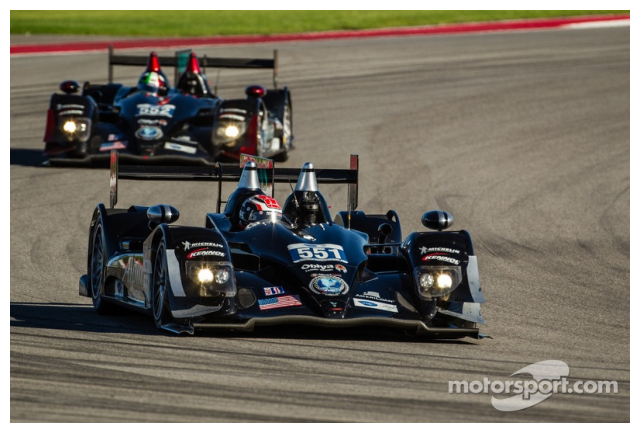

In [6]:
show_image(df_consolidated, idx=None)

In [7]:
vae = AutoencoderKL.from_pretrained("ostris/vae-kl-f8-d16")
_ = vae.requires_grad_(False)

(398, 408, 3)


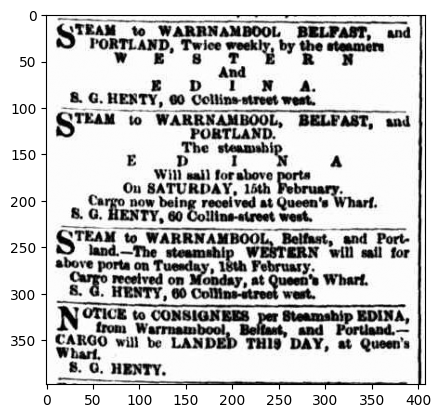

In [8]:
path = df_consolidated.sample(1)['path'][0]
img_ = Image.open(path).convert('RGB')
img = np.array(img_) / 255.
print(img.shape)
plt.imshow(img)

In [9]:
z = vae.encode(torch.Tensor(img).permute(2, 0, 1)[None]).latent_dist.sample()
img_rec = vae.decode(z).sample

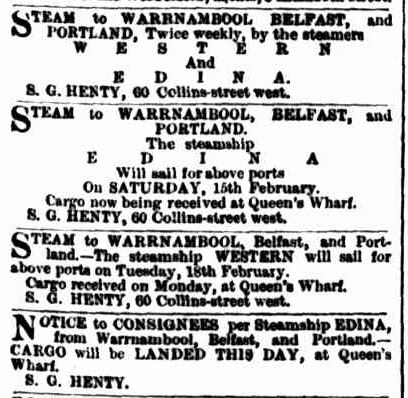

In [10]:
img_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28704783..1.0780532].


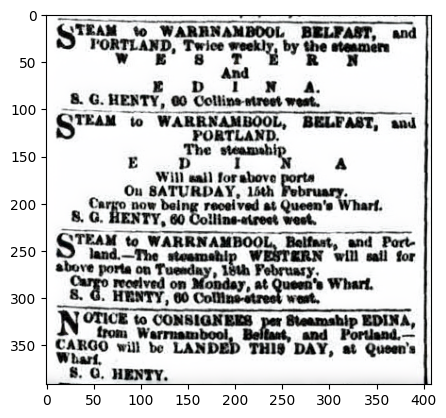

In [11]:
plt.imshow(img_rec[0].permute(1, 2, 0))

In [12]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pile-t5-base", use_fast=True)
tokenizer.pad_token = tokenizer.bos_token
model = AutoModelForSeq2SeqLM.from_pretrained("EleutherAI/pile-t5-base")